# **GNN - Final Project**  
#### Made by Emil Thorsbjerg (thorsemi)

In the first section, I install the required packages for using PyTorch Geometric to build and train Graph Neural Networks.

In [1]:
!pip install torch-geometric
!pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

I import the necessary libraries and load the PubMed dataset using PyTorch Geometric. The features are normalized, and the graph data is prepared for training. I also initialize a list to store loss values during training.

In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
import torch.nn.functional as F

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=T.NormalizeFeatures())
data = dataset[0]
loss_values = []

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/libpyg.so: undefined symbol: _ZN2at4_ops10zeros_like4callERKNS_6TensorEN3c108optionalINS5_10ScalarTypeEEENS6_INS5_6LayoutEEENS6_INS5_6DeviceEEENS6_IbEENS6_INS5_12MemoryFormatEEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-

In this section, I define the Graph Convolutional Network (GCN) model with two layers. The first layer applies a graph convolution followed by ReLU activation and dropout. The second layer outputs class scores using log-softmax for node classification.

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In this section, I configure the computation device (CPU or GPU), initialize the GCN model with input, hidden, and output dimensions, move the model and data to the selected device, and define the Adam optimizer for training.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=data.num_node_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In this section, I define the training and testing functions. The `train` function performs one training step using negative log-likelihood loss, while the `test` function evaluates model accuracy on the training, validation, and test sets.

In [5]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

# **Training the model**
In this section, I train the model for 200 epochs, print performance every 20 epochs, and store the loss value from each epoch for later visualization.

In [6]:
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
for epoch in range(1, 201):
    loss = train()
    loss_values.append(loss)
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch: 020, Loss: 0.9236, Train Acc: 0.9167, Val Acc: 0.7240, Test Acc: 0.7180
Epoch: 040, Loss: 0.6852, Train Acc: 0.9500, Val Acc: 0.7460, Test Acc: 0.7430
Epoch: 060, Loss: 0.4787, Train Acc: 0.9500, Val Acc: 0.7980, Test Acc: 0.7760
Epoch: 080, Loss: 0.3579, Train Acc: 0.9833, Val Acc: 0.7960, Test Acc: 0.7860
Epoch: 100, Loss: 0.3318, Train Acc: 0.9833, Val Acc: 0.8040, Test Acc: 0.7860
Epoch: 120, Loss: 0.2859, Train Acc: 0.9833, Val Acc: 0.8140, Test Acc: 0.7870
Epoch: 140, Loss: 0.2505, Train Acc: 1.0000, Val Acc: 0.7980, Test Acc: 0.7860
Epoch: 160, Loss: 0.2141, Train Acc: 1.0000, Val Acc: 0.7980, Test Acc: 0.7910
Epoch: 180, Loss: 0.1955, Train Acc: 1.0000, Val Acc: 0.8020, Test Acc: 0.7910
Epoch: 200, Loss: 0.1595, Train Acc: 1.0000, Val Acc: 0.8020, Test Acc: 0.7870
Epoch: 020, Loss: 0.2075, Train Acc: 1.0000, Val Acc: 0.7940, Test Acc: 0.7870
Epoch: 040, Loss: 0.1732, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.7900
Epoch: 060, Loss: 0.1514, Train Acc: 1.0000, Val Acc

# **Visualizes the training loss**
In this section, I plot the training loss over 200 epochs to visualize how the model's loss evolves during training.

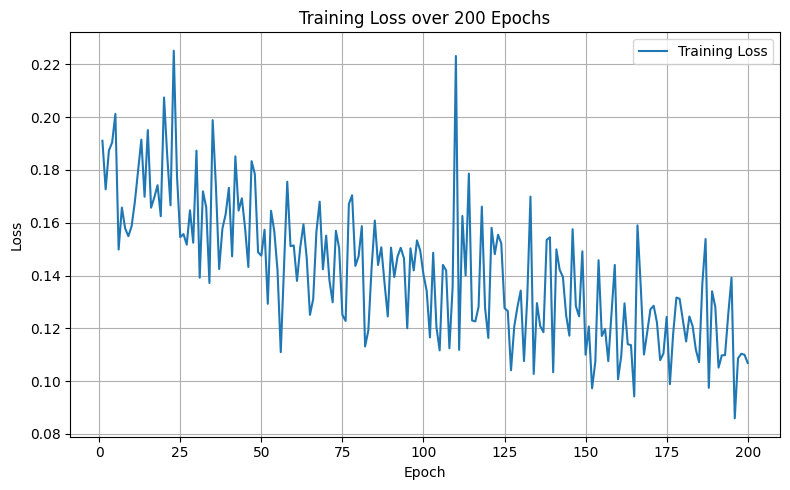

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, 201), loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over 200 Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

# **t-SNE Visualization**
In this section, I extract the hidden node embeddings from the first GCN layer and use t-SNE to reduce them to two dimensions for visualization, showing how well the model separates different classes in the embedding space.

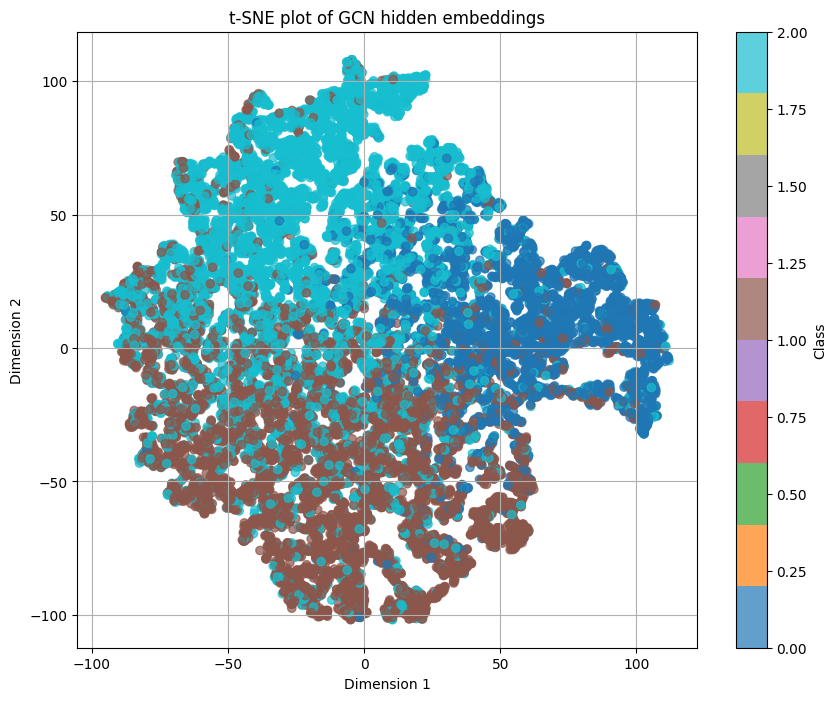

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    hidden = model.conv1(data.x, data.edge_index)
    hidden = hidden.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(hidden)

y = data.y.cpu().numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE plot of GCN hidden embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


# **Confusion matrix to evaluate the model's classification**
In this section, I define the GCN model architecture using PyTorch. It consists of two graph convolutional layers, where the first layer applies ReLU activation and dropout, and the second outputs log-probabilities for node classification.

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In this section, I load the PubMed dataset using the Planetoid class from PyTorch Geometric and apply feature normalization to prepare the graph data for training.

In [10]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=T.NormalizeFeatures())
data = dataset[0]

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=data.num_node_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In this section, I generate a confusion matrix to evaluate the model's classification performance on the test set, highlighting where misclassifications occur between the three classes.

<Figure size 600x600 with 0 Axes>

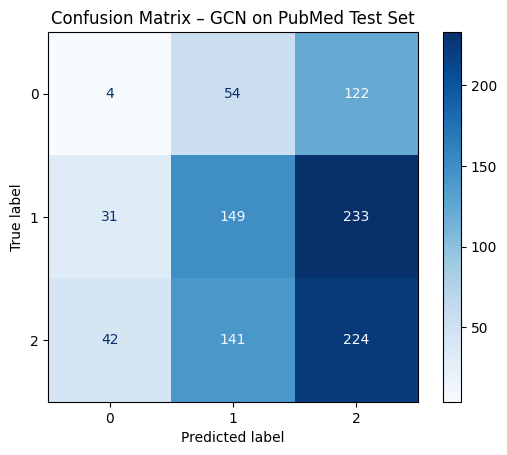

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

test_mask = data.test_mask.cpu().numpy()
y_test = y_true[test_mask]
y_pred = pred[test_mask]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix – GCN on PubMed Test Set")
plt.show()

# **Prediction Examples**
In this section, I create a DataFrame containing predictions for the test nodes and display five correct and five incorrect examples to better understand where the model performs well and where it makes mistakes.

In [13]:
import pandas as pd

test_node_ids = data.test_mask.nonzero(as_tuple=True)[0].cpu().numpy()
df = pd.DataFrame({
    'Node ID': test_node_ids,
    'True Label': y_test,
    'Predicted Label': y_pred
})
df['Correct'] = df['True Label'] == df['Predicted Label']
wrong_examples = df[df['Correct'] == False].sample(5, random_state=1)
correct_examples = df[df['Correct'] == True].sample(5, random_state=1)
print("Examples of incorrect predictions:")
display(wrong_examples)

print("\n Examples of correct predictions:")
display(correct_examples)

Examples of incorrect predictions:


,Node ID,True Label,Predicted Label,Correct
572,19289,2,1,False
271,18988,2,1,False
138,18855,2,1,False
102,18819,1,2,False
994,19711,0,2,False



 Examples of correct predictions:


,Node ID,True Label,Predicted Label,Correct
362,19079,2,2,True
584,19301,1,1,True
224,18941,1,1,True
425,19142,1,1,True
260,18977,1,1,True
